In [37]:
import os 
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

In [53]:
df= pd.read_csv("american_train_100.csv")

In [54]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel9990,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999
0,A,170,171,171,170,172,171,171,171,170,...,130,131,130,128,130,129,129,128,128,128
1,A,174,174,174,174,174,172,174,175,173,...,139,139,141,142,142,140,140,136,140,140
2,A,172,170,170,170,170,171,170,170,171,...,131,130,128,128,127,129,127,128,129,128
3,A,170,168,168,169,170,167,169,169,167,...,141,140,142,142,141,142,143,142,142,141
4,A,168,168,168,167,169,169,169,169,170,...,141,142,140,141,142,142,139,141,142,139


In [55]:
# separamos en conjunto de entrenamiento y de prueba
X = df.drop('label',axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel9990,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999
0,170,171,171,170,172,171,171,171,170,171,...,130,131,130,128,130,129,129,128,128,128
1,174,174,174,174,174,172,174,175,173,172,...,139,139,141,142,142,140,140,136,140,140
2,172,170,170,170,170,171,170,170,171,170,...,131,130,128,128,127,129,127,128,129,128
3,170,168,168,169,170,167,169,169,167,170,...,141,140,142,142,141,142,143,142,142,141
4,168,168,168,167,169,169,169,169,170,169,...,141,142,140,141,142,142,139,141,142,139


In [57]:
from sklearn.preprocessing import LabelBinarizer
# convertimos las etiquetas a números 
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [122]:
# Normalizamos los datos entre el minimo y el maximo
X_train = X_train / 255.0
X_test = X_test / 255.0

In [59]:
# Aplicamos reshape para que las imágenes tengan 3 dimensiones
# x_train = X_train.values.reshape(-1,28,28,1)
# x_test = X_test.values.reshape(-1,28,28,1)

# Aplicamos reshape para que las imágenes tengan 3 dimensiones
x_train = X_train.values.reshape(-1,100,100,1)
x_test = X_test.values.reshape(-1,100,100,1)

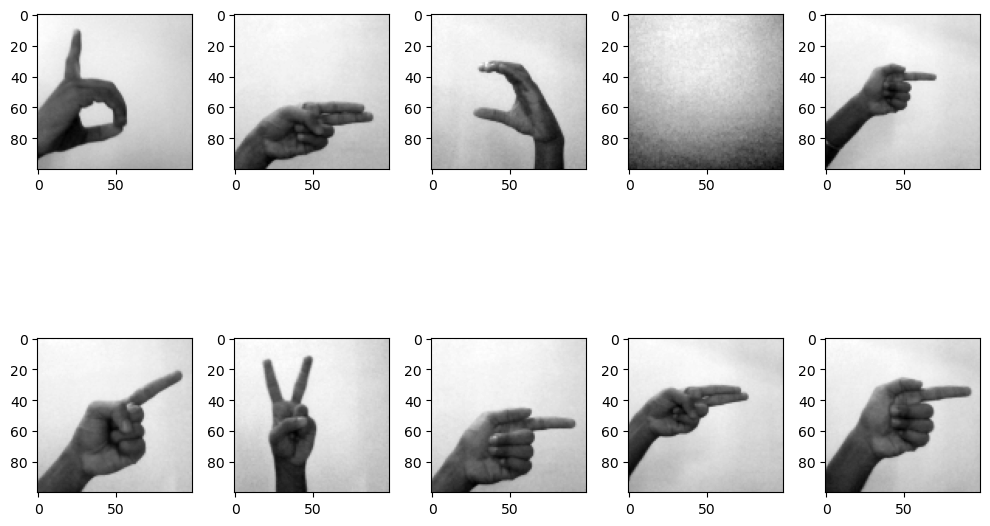

In [60]:
# Preview de 10 imágenes 
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        # ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        ax[i,j].imshow(x_train[k].reshape(100, 100) , cmap = "gray")
        k += 1
    plt.tight_layout()    


In [ ]:
# Preparamos el modelo
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
# model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (100,100,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 28 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 75)      750       
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 75)     300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 50)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50, 50)      

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10


2022-11-26 21:30:17.122962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7976

2022-11-26 21:30:46.034959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 31s 172ms/step - loss: 0.7319 - accuracy: 0.7976 - val_loss: 16.5751 - val_accuracy: 0.0370 - lr: 0.0010
Epoch 2/10
175/175 [==============================] - 29s 167ms/step - loss: 0.0683 - accuracy: 0.9791 - val_loss: 20.8630 - val_accuracy: 0.0370 - lr: 0.0010
Epoch 3/10
175/175 [==============================] - 29s 165ms/step - loss: 0.0338 - accuracy: 0.9898 - val_loss: 11.5594 - val_accuracy: 0.1089 - lr: 0.0010
Epoch 4/10
175/175 [==============================] - 29s 166ms/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 4.4207 - val_accuracy: 0.4980 - lr: 0.0010
Epoch 5/10
175/175 [==============================] - 29s 165ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.1310 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 6/10
175/175 [==============================] - 29s 165ms/step - loss: 0.0248 - accuracy: 0.9929 - val_loss: 0.3467 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 7/10
175/175 [==============================] - ETA: 0

In [ ]:
# A continuacion, tenemos que crear un archivo de etiquetas que contendra todas nuestras etiquetas (importante para Flutter)
labels = '\n'.join(sorted(df.label.unique()))
with open('labels.txt', 'w') as f: # escribe en el archivo labels.txt, y si no existe, lo crea, y si existe, lo sobreescribe. (eso es lo que 'w' es para)
    f.write(labels)

In [ ]:
# con nuestra red neuronal entrenada con tensorflow y keras, podemos exportarla
saved_model_dir = '' # directorio donde se guardara el modelo
tf.saved_model.save(model, saved_model_dir) # guarda el modelo en el directorio

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() # convierte el modelo en un modelo de tensorflow lite, que pueda usar flutter 
with open('model.tflite', 'wb') as f: # guardamos el modelo en un archivo llamado model.tflite, y si no existe, lo crea, y si existe, lo sobreescribe. (eso es lo que 'wb' es para)
  f.write(tflite_model)

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmphumsl2ns/assets


INFO:tensorflow:Assets written to: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmphumsl2ns/assets
2022-11-26 21:35:17.468052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-26 21:35:17.468071: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-26 21:35:17.468209: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmphumsl2ns
2022-11-26 21:35:17.470603: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-26 21:35:17.470610: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmphumsl2ns
2022-11-26 21:35:17.478998: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-26 21:35:17.561714: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

In [48]:
# Cargamos el modelo
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Obtenemos las entradas y salidas del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



1/1 [==============================] - 0s 14ms/step
D 0.99997866
F 1.9940493e-05
O 1.2830687e-06
K 8.74194e-08
SPACE 7.1442745e-09


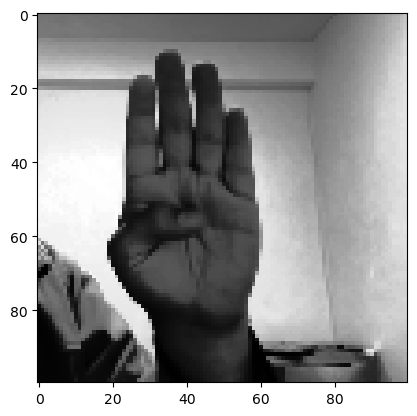

In [127]:
img = cv2.imread('dataset/alan/b1.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.equalizeHist(img_gray)
img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
img_gray = cv2.resize(img_gray, (100, 100))
img_array = np.array(img_gray)
img_array = img_array/255.0
# normalizamos la imagen entre el valor minimo y el maximo entre 0 y 1
# img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
img_array = img_array.reshape(-1, 100, 100, 1)
img_array = img_array.astype(np.float32)

predictions = model.predict(img_array)

# Predecimos
input_shape = input_details[0]['shape']
input_data = np.array(img_array)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)

# Mostramos el resultado
top_k = results.argsort()[-5:][::-1]
labels = open('labels.txt').read().splitlines()
for i in top_k:
    print(labels[i], results[i])

# Mostramos la imagen
plt.imshow(img_gray.reshape(100, 100), cmap = "gray")